# Handwritten Digits Classification

Here we will apply the models from the simulations to a real dataset consisting of handwritten digits. We the USPS dataset and choose to discriminate between digits with loops and without loops (ignoring 4 to form a balanced problem).

## Setup

In [36]:
#Importing libraries

#Basic libraries

%pylab inline
import h5py
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
import seaborn as sns

#For GP models

import GPy
from scipy import optimize

#For logistic regression 

from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit

#Libraries for importing data files

import sys
import os

ROOT = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(ROOT, 'Data'))


Populating the interactive namespace from numpy and matplotlib


In [35]:
#Configuring plot styles

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

## Importing Dataset

US Postal Service (USPS) database of handwritten digits which  consists of 9298 segmented 16 × 16 greyscale images normalized so that the intensity of the pixels lies in $\left[−1, 1\right]$.
The dataset can be accessed from [here](https://www.kaggle.com/bistaumanga/usps-dataset).

In [47]:
#Importing dataset

path_data = os.path.join(ROOT, 'Data')
sys.path.insert(0, ROOT)

filename = os.path.join(path_data,'USPS_Digits.h5')

with h5py.File(filename, 'r') as USPS:
        train = USPS.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = USPS.get('test')
        X_test = test.get('data')[:]
        y_test = test.get('target')[:]

In [ ]:
#Getting random 16 images from train and test

np.random.seed(42)
train_ind = np.random.randint(low=0,high=X_train.shape[0]+1, size=20)

np.random.seed(41)
test_ind = np.random.randint(low=0,high=X_test.shape[0]+1, size=20)

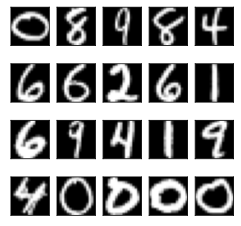

In [42]:
#Some images from the training dataset

fig = plt.figure(figsize=(4,4))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(X_train[train_ind[i]].reshape(16,16), cmap=plt.cm.gray)
    #plt.title('Training: %i\n' % all_labels[i], fontsize = 10)
    
plt.savefig("Images_training_original.png", dpi=1000)

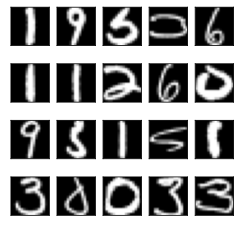

In [43]:
#Some images from the test dataset

fig = plt.figure(figsize=(4,4))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(X_test[test_ind[i]].reshape(16,16), cmap=plt.cm.gray)
    #plt.title('Training: %i\n' % all_labels[i], fontsize = 10)
    
plt.savefig("Images_test_original.png", dpi=1000)

## Data-Preprocessing

In [48]:
#Pooling train and test sets together

all_digits = np.concatenate((X_train, X_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

print(f'Shape of all digits: {all_digits.shape}')

Shape of all digits: (9298, 256)


### Transforming Dataset for Binary Classification

In [ ]:
#Binary classification of digits with and without loops is chosen
#Motivated by the similarity of the digit's handwritten form as displayed below

k = [0,6,8,9]
l = [1,2,3,5]

k_bool = ((all_labels == k[0]) | (all_labels == k[1]) | (all_labels == k[2]) | (all_labels == k[3]))
l_bool = ((all_labels == l[0]) | (all_labels == l[1]) | (all_labels == l[2]) | (all_labels == l[3]))

where_k = np.where(k_bool)
where_l = np.where(l_bool)

labels_k = all_labels[where_k] 
digits_k = all_digits[where_k]
labels_l = all_labels[where_l]
digits_l = all_digits[where_l]

### Partitioning Dataset

In [ ]:
#Partitioning dataset into only ks and ls for a binary classification problem

np.random.seed(42)

partition = np.where((k_bool) | (l_bool))
partition_labels = all_labels[partition]
partition_digits = all_digits[partition]

## Model fitting

### Train-test split

In [ ]:
#Splitting into test-train split with 0.75 training set

from sklearn.model_selection import train_test_split

#Test-train split

X_train, X_test, y_train, y_test = train_test_split(partition_digits, partition_labels, train_size = .75, random_state = 42)

In [52]:
#Transforming binary output into appropriate form

#Labelling ks as 0 and ls as 1

k_bool_train = ((y_train == k[0]) | (y_train == k[1]) | (y_train == k[2]) | (y_train == k[3]))
l_bool_train = ((y_train == l[0]) | (y_train == l[1]) | (y_train == l[2]) | (y_train == l[3]))
y_train[k_bool_train] = 0
y_train[l_bool_train] = 1

k_bool_test = ((y_test == k[0]) | (y_test == k[1]) | (y_test == k[2]) | (y_test == k[3]))
l_bool_test = ((y_test == l[0]) | (y_test == l[1]) | (y_test == l[2]) | (y_test == l[3]))
y_test[k_bool_test] = 0
y_test[l_bool_test] = 1

In [77]:
#Getting some images from repartitioned training and test sets

np.random.seed(42)
train_ind = np.random.randint(low=0,high=X_train.shape[0]+1, size=20)

np.random.seed(59)
test_ind = np.random.randint(low=0,high=X_test.shape[0]+1, size=20)

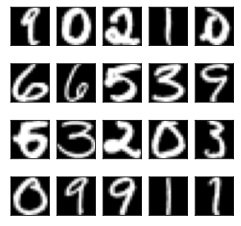

In [67]:
#Some images from the training dataset

fig = plt.figure(figsize=(4,4))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(X_train[train_ind[i]].reshape(16,16), cmap=plt.cm.gray)
    #plt.title('Training: %i\n' % all_labels[i], fontsize = 10)
    
plt.savefig("Images_training_partitioned.png", dpi=1000)

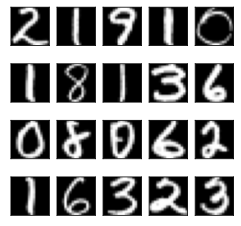

In [78]:
#Some images from the training dataset

fig = plt.figure(figsize=(4,4))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(X_test[test_ind[i]].reshape(16,16), cmap=plt.cm.gray)
    #plt.title('Training: %i\n' % all_labels[i], fontsize = 10)
    
plt.savefig("Images_test_partitioned.png", dpi=1000)

### Variational GP Classification

### SVGP

In [ ]:
#Creating necessary variables

dim = X_train.shape[1]
comp_times = ({"SVGP": .0, "FVGP": .0, 
                        "LGP": .0, "LR": .0})
CRRs = ({"SVGP": .0, "FVGP": .0, 
                        "LGP": .0, "LR": .0})

y_train = y_train.reshape(y_train.size, 1)
y_test = y_test.reshape(y_test.size, 1)


In [39]:
#For this method we require inducing input points, Z
#We will choose 10% of training size as inducing input points.

n = int(0.10*y_train.size)

#Choosing n random points from training set as inducing points to be optimized

np.random.seed(42)
points = np.random.randint(low=0, high=y_train.size, size=n)
Z_train = X_train[points,:]

In [38]:
#Creating sparse varational GP classification model
#Originally with white noise and RBF kernel, but subsequently removed white noise kernel

m = GPy.core.SVGP(X_train, y_train, kernel=GPy.kern.RBF(dim)+GPy.kern.White(dim), likelihood=GPy.likelihoods.Bernoulli(), Z=Z_train)

In [39]:
#Optimizing model

mean_t = 0
for i in range(5):
    
    t0 = time.time()
    m.optimize('bfgs')
    t1 = time.time()
    mean_t += t1-t0

comp_times["SVGP"] = mean_t

In [41]:
mean_t = mean_t/(60*60)
print(f"Mean computation time for SVGP M=10%: {round(mean_t,2)} hours")

Mean computation time for SVGP M=10%: 2.16 hours


In [41]:
#Model output

m

SVGP.,value,constraints,priors
inducing inputs,"(119, 256)",,
sum.rbf.variance,25.368277926995773,+ve,
sum.rbf.lengthscale,7.981245701143451,+ve,
sum.white.variance,4.654328447676013e-06,+ve,
q_u_chol,"(7140, 1)",,
q_u_mean,"(119, 1)",,


In [43]:
#Predictons

predict_sparse_var_10 = m.predict(X_test)[0]
classification_sparse_var_10 = np.where(predict_sparse_var_10 >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var_10 == y_test)[0].size/y_test.size    #corect classification rate
CRRs["SVGP"][10] = CRR_sparse_var
CRR_sparse_var

print(f'CRR for SVGP: {CRR_sparse_var}')

CRR for SVGP: 0.97645412130638


### FVGP

In [43]:
#Creating full GP model without sparse approximations

m = GPy.models.GPVariationalGaussianApproximation(X_train, y_train, kernel=GPy.kern.RBF(dim)+GPy.kern.White(dim), likelihood=GPy.likelihoods.Bernoulli())

In [44]:
#Optimizing model

mean_t = 0
for i in range(5):
    
    t0 = time.time()
    m.optimize('bfgs')
    t1 = time.time()
    mean_t += t1-t0

comp_times["FVGP"] = mean_t

In [44]:
mean_t = mean_t/(60*60)
print(f"Mean computation time for FVGP: {round(mean_t,2)} hours")

Mean computation time for FVGP: 8.83 hours


In [46]:
#Model output

m

VarGP.,value,constraints,priors
sum.rbf.variance,10.277176099689237,+ve,
sum.rbf.lengthscale,9.176128173835817,+ve,
sum.white.variance,0.0006261030999313069,+ve,
alpha,"(1193, 1)",,
beta,"(1193,)",,


In [45]:
#Predictons

predict_full_var = m.predict(X_test)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == y_test)[0].size/y_test.size    #corect classification rate
CRRs["FVGP"] = CRR_full_var
CRR_full_var

print(f'CRR for FVGP: {CRR_full_var}')

CRR for FVGP: 0.9748989113530326


#### LGP

In [48]:
#Creating Laplacian inference model

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
kl = GPy.kern.RBF(dim, variance=1., lengthscale=1)+GPy.kern.White(dim)     #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m = GPy.core.GP(X=X_train,
                Y=y_train, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)


In [49]:
#Optimizing  model

mean_t = 0
for i in range(5):
    
    t0= time.time()
    m.optimize('bfgs', max_iters=100)
    t1 = time.time()
    mean_t += t1-t0
    
comp_times["LGP"] = mean_t

In [46]:
mean_t = mean_t/(60*60)
print(f"Mean computation time for LGP: {round(mean_t,2)} hours")

Mean computation time for LGP: 2.23 hours


In [51]:
#Model output

m

gp.,value,constraints,priors
sum.rbf.variance,28.35133414561903,+ve,
sum.rbf.lengthscale,7.178758363635524,+ve,
sum.white.variance,9.410257827309386e-06,+ve,


In [48]:
#Predictons

predict_laplace = m.predict(X_test)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == y_test)[0].size/y_test.size    #corect classification rate
CRRs["LGP"] = CRR_laplace
CRR_laplace

print(f'CRR for LGP: {CRR_laplace}')

CRR for LGP: 0.975674961119751


#### Logistic Regression

In [42]:
#Logistic regression with statsmodels API
#Fitting logistic regression model with logit link, including intercept term

X_train_design = add_constant(X_train)

m = sm.GLM(y_train, X_train_design, family=sm.families.Binomial()).fit()
t1 = time.time()

 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning:divide by zero encountered in true_divide
 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning:overflow encountered in exp
 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning:divide by zero encountered in true_divide
 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning:invalid value encountered in true_divide


PerfectSeparationError: Perfect separation detected, results not available

## Results

### ROC Curves and AUCs

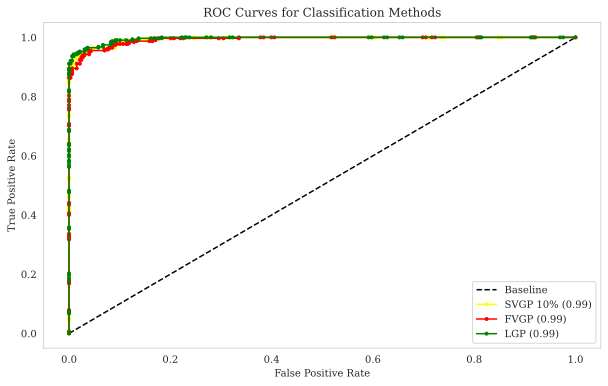

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#ROC Curves

sparse_var_fpr, sparse_var_tpr, thresholds = roc_curve(y_test, predict_sparse_var_10)
full_var_fpr, full_var_tpr, thresholds = roc_curve(y_test, predict_full_var)
GP_laplace_fpr, GP_laplace_tpr, thresholds = roc_curve(y_test, predict_laplace)
#log_r_fpr, log_r_tpr, thresholds = roc_curve(y_test, predict_log_r)

#AUCs

sparse_var_AUC= roc_auc_score(y_test, predict_sparse_var_10)
full_var_AUC = roc_auc_score(y_test, predict_full_var)
GP_laplace_AUC = roc_auc_score(y_test, predict_laplace)

#Plots

plt.plot([0,1], [0,1], linestyle='--', color="Black", label="Baseline")
plt.plot(sparse_var_fpr, sparse_var_tpr, marker=".", color="Yellow", label=f'SVGP 10% ({round(sparse_var_AUC,2)})')
plt.plot(full_var_fpr, full_var_tpr, marker=".", color="Red", label=f'FVGP ({round(full_var_AUC,2)})')
plt.plot(GP_laplace_fpr, GP_laplace_tpr, marker=".", color="Green", label=f'LGP ({round(GP_laplace_AUC,2)})')

plt.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves for Classification Methods")
plt.legend(loc="best")
plt.savefig('ROC_Curves_Digits.png', dpi=1000)
plt.show()
